In [1]:
from causalsim import *
import metrics
from econml.metalearners import XLearner
from econml.dr import DRLearner
from econml.dml import CausalForestDML
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Data Generation 
#### Simple model: Treatment effect for individual i: \tau_i = \beta * x_{i1} 

In [2]:
n = 1000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data = simulation_simple(n = n, p = p, beta = beta, sigma = sigma)
print(data.head(10))

         X1       tau  Z   epsilon         Y
0 -0.992612 -0.992612  1 -0.285190 -1.277802
1 -0.044465 -0.044465  0 -0.054316 -0.054316
2 -1.401983 -1.401983  0 -2.365355 -2.365355
3 -0.477045 -0.477045  0  0.336008  0.336008
4  0.163588  0.163588  1  0.123782  0.287369
5 -0.674642 -0.674642  0  0.832419  0.832419
6 -0.781694 -0.781694  0  0.619402  0.619402
7 -0.167887 -0.167887  1 -0.995521 -1.163408
8 -0.235386 -0.235386  0  0.065370  0.065370
9 -0.821607 -0.821607  1 -0.007414 -0.829022


#### Categorical Model

In [3]:
n = 1000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data_cat = simulation_categorical(n = n, p = p, beta = beta, sigma = sigma)
print(data_cat.head(10))

         X1       tau  Z   epsilon         Y
0 -1.198855  0.000000  0  0.065355  0.065355
1 -1.814755  0.000000  1 -0.688238 -0.688238
2  0.107504  0.107504  0  0.720693  0.720693
3 -1.380556  0.000000  1  0.663924  0.663924
4 -0.857801  0.000000  0 -2.000775 -2.000775
5  0.648159  0.648159  0 -1.707034 -1.707034
6  0.484355  0.484355  0  0.460189  0.460189
7 -2.353524  0.000000  0 -1.193591 -1.193591
8 -0.007999  0.000000  1  0.325661  0.325661
9  1.435496  1.435496  1  1.892639  3.328135


#### Assigning variables for econml metalearner functions

In [4]:
X = data[[col for col in data.columns if col.startswith('X')]]
T = data['Z'] #treatment indicator
y = data['Y']
tau = np.array(data['tau'])

## Linear Regression

#### y ~ X + Z + X*Z

In [5]:
data['X1*Z'] = data['X1'] * data['Z'] #Setting interaction term
lr_xfit = data[['X1', 'Z', 'X1*Z']]

lr = LinearRegression() #Fit linear regression
lr.fit(lr_xfit, data['Y'])
y_hat = lr.predict(lr_xfit)

mse_lr, bias_lr, r2_lr = metrics.evaluate(data['Y'], y_hat)

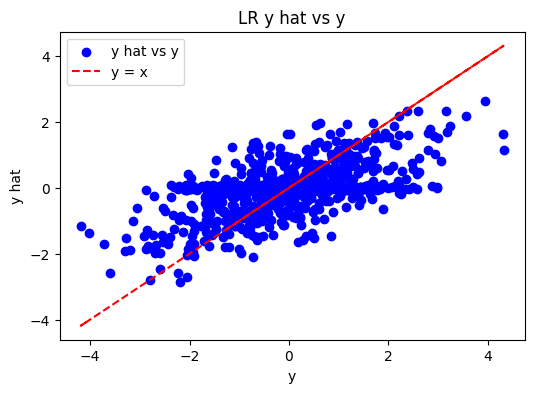

In [6]:
plt.figure(figsize=(6, 4)) 
plt.scatter(data['Y'], y_hat, color='blue', label='y hat vs y')
plt.plot(data['Y'], data['Y'], color='red', linestyle='--', label='y = x')  # y=x

plt.title('LR y hat vs y')
plt.xlabel('y')
plt.ylabel('y hat')
plt.legend()
plt.show()

In [7]:
print(f'LR metrics:\nMse: {mse_lr}\nBias: {bias_lr}\nR2 {r2_lr}')

LR metrics:
Mse: 0.9905985789049142
Bias: 7.105427357601002e-18
R2 0.33437942963033285


## X-Learner

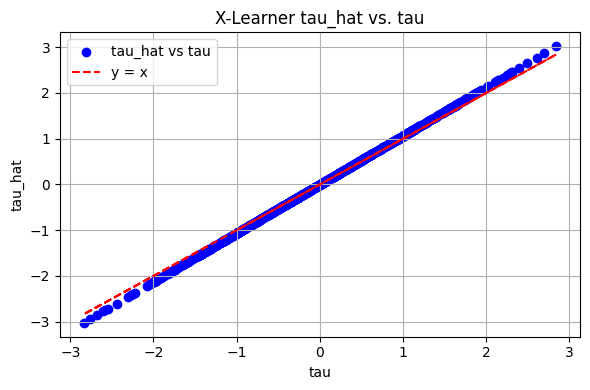

In [8]:
est = XLearner(models=LinearRegression())
est.fit(y, T, X=X)
tau_hat_x = est.effect(X)

mse_x, bias_x, r2_x = metrics.evaluate(tau, tau_hat_x)
metrics.tau_plot(tau, tau_hat_x, 'X-Learner tau_hat vs. tau')

In [9]:
print(f'X-learner metrics:\nMse: {mse_x}\nBias: {bias_x}\nR2 {r2_x}')

X-learner metrics:
Mse: 0.004028325735147916
Bias: 0.003802553206334067
R2 0.9958281746147271


## DR-Learner

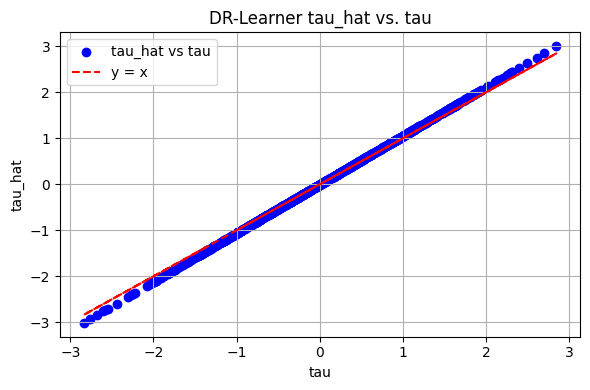

In [10]:
est = DRLearner()
est.fit(y, T, X=X, W=None)
tau_hat_dr = est.effect(X)

mse_dr, bias_dr, r2_dr = metrics.evaluate(tau, tau_hat_dr)
metrics.tau_plot(tau, tau_hat_dr, 'DR-Learner tau_hat vs. tau')

In [11]:
print(f'DR-learner metrics:\nMse: {mse_dr}\nBias: {bias_dr}\nR2 {r2_dr}')

DR-learner metrics:
Mse: 0.0033067226111666253
Bias: 0.008459987966440695
R2 0.9965754831564497


## Causal Forest

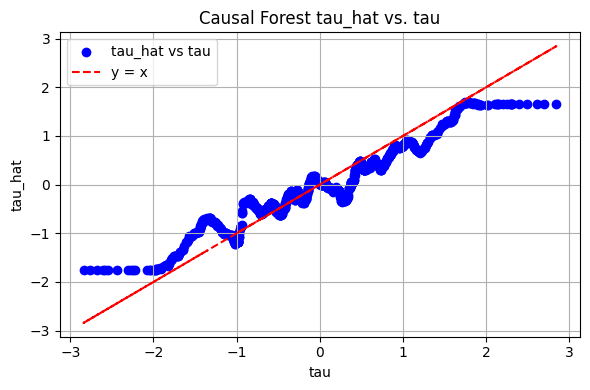

In [12]:
est = CausalForestDML(discrete_treatment=True)
est.fit(y, T, X=X, W=None)
tau_hat_cf = est.effect(X)

mse_cf, bias_cf, r2_cf = metrics.evaluate(tau, tau_hat_cf)
metrics.tau_plot(tau, tau_hat_cf, 'Causal Forest tau_hat vs. tau')

In [13]:
print(f'Causal Forest metrics:\nMse: {mse_cf}\nBias: {bias_cf}\nR2 {r2_cf}')

Causal Forest metrics:
Mse: 0.09446673250095336
Bias: 0.03307047868755363
R2 0.9021681118603003
